In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q karateclub
!pip install -q lightgbm
import warnings
warnings.filterwarnings('ignore')
import random
import numpy as np
import pandas as pd
def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)

     |████████████████████████████████| 62 kB 764 kB/s 
     |████████████████████████████████| 1.8 MB 10.8 MB/s 
     |████████████████████████████████| 24.1 MB 1.7 MB/s 
     |████████████████████████████████| 50 kB 4.7 MB/s 


# Load the network

In [ ]:
#@title  { run: "auto", form-width: "30%" }
network = "PPI" #@param ["PPI", "Met", "Met+PPI"]
import tqdm as tq
import pandas as pd
import networkx as nx
import os

datapath = "/content/drive/MyDrive/CDS-GROUP-ROOT/BIOMAT2022/datasets" #@param {type:"string"}
#datapath = "./datasets" 
df_net = pd.read_csv(os.path.join(datapath,f'{network.lower()}_edges.csv'))
df_net

,source,target,weight
0,ENSG00000068366,ENSG00000123983,75.8
1,ENSG00000068366,ENSG00000140284,210.4
2,ENSG00000068366,ENSG00000151726,274.4
3,ENSG00000068366,ENSG00000197142,57.2
4,ENSG00000110090,ENSG00000151726,267.8
...,...,...,...
573953,ENSG00000115694,ENSG00000182866,47.0
573954,ENSG00000108691,ENSG00000160791,104.9
573955,ENSG00000186889,ENSG00000183853,16.1
573956,ENSG00000146731,ENSG00000086758,109.6


# Read the labels
Load the label file, select the label type, and print label distribution

working on label "CS0_vs_CS6-9": {'E': 0, 'NE': 1}


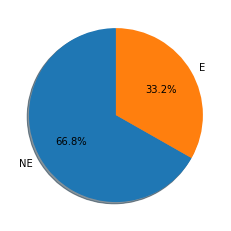

In [ ]:
from sklearn import preprocessing
from collections import Counter
import matplotlib.pyplot as plt
#@title Testo del titolo predefinito { run: "auto", form-width: "20%" }
labelfile = "multiLabels" #@param {type:"string"}
labelname = "label_CS_ACH_most_freq" #@param ["label", "avana0", "avana10", "label_CS_ACH_most_freq"]
import pandas as pd
import numpy as np
df_label = pd.read_csv(os.path.join(datapath,f'{labelfile}.csv'))
df_label['name'] = genes = df_label.index.values                                            # get genes with defined labels (E or NE)
df_label = df_label.reset_index()                                                           # reindex genes by consecutive integers
df_label['index'] = df_label.index
gene2idx_mapping = { v[1] : v[0]  for v in df_label[['index', 'name']].values }             # create mapping index by gene name
idx2gene_mapping = { v[0] : v[1]  for v in df_label[['index', 'name']].values }             # create mapping index by gene name
if labelname == "label_CS_ACH_most_freq":
    E_class, NE_class = ['CS0', 'CS1'], ['CS6', 'CS7', 'CS8', 'CS9']
    new_label_name = 'CS0_vs_CS6-9'
    df_label[new_label_name] = df_label.apply(lambda row: 'E' if row[labelname] in E_class \
                                        else 'NE' if row[labelname] in NE_class \
                                        else 'ND', axis=1)
    labelname = new_label_name
exclude_labels = ['ND']
df_label = df_label[df_label[labelname].isin(exclude_labels) == False]                      # drop any row contaning NaN or SC1-SC5 as value
distrib = Counter(df_label[labelname].values)
selectedgenes = df_label['name'].values
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(df_label[labelname].values)  
classes_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
plt.pie(list(distrib.values()), labels=list(distrib.keys()), autopct='%2.1f%%', shadow=True, startangle=90)
print(f'working on label "{labelname}": {classes_mapping}')
plt.show()

# Load attributes to be used
We identified three sets of attributes:
1. bio attributes, related to gene information (such as, expression, etc.)
1. GTEX-* attribute, additional biological information of genes 
Based on user selection, the node attributes are appended in a single matrix of attributes (`x`)

In the attribute matrix `x` there can be NaN or Infinite values. They are corrected as it follow:
+ NaN is replaced by the mean in the attribute range, 
+ Infinte value is replaced by the maximum in the range.

After Nan and Infinite values fixing, the attributes are normalized with Z-score or MinMax normalization functions.

At the end, only nodes (genes) with E or NE labels are selected for the classification

In [ ]:
#@title Choose attributes { form-width: "20%" }
normalize_node = "" #@param ["", "zscore", "minmax"]
bio = True #@param {type:"boolean"}
gtex = True #@param {type:"boolean"}
variable_name = "bio"
x = pd.read_csv(os.path.join(datapath,'integratedNet_nodes_bio.csv'))
x = x.drop(columns=['id'])
print(f'Found {x.isnull().sum().sum()} NaN values and {np.isinf(x).values.sum()} Infinite values')
for col in x.columns[x.isna().any()].tolist():
  mean_value=x[col].mean()          # Replace NaNs in column with the mean of values in the same column
  if mean_value is not np.nan:
    x[col].fillna(value=mean_value, inplace=True)
  else:                             # otherwise, if the mean is NaN, remove the column
    x = x.drop(col, 1)
if normalize_node == 'minmax':
  print("X attributes normalization (minmax)...")
  x = (x-x.min())/(x.max()-x.min())
elif normalize_node == 'zscore':
  print("X attributes normalization (zscore)...")
  x = (x-x.mean())/x.std()
x = x.loc[selectedgenes]
print(f'New attribute matrix x{x.shape}')

Found 1996 NaN values and 0 Infinite values
New attribute matrix x(4596, 105)


# Load the PPI+MET network
The PPI networks is loaded from a CSV file, where
*   `A` is the column name for edge source (gene index)
*   `B` is the column name for edge target (gene index)
*   `weight` is the column name for edge weight


In [ ]:
import networkx as nx
edge_list = [(gene2idx_mapping[v[0]], gene2idx_mapping[v[1]], v[2]) for v in list(df_net[['source','target', 'weight']].values)]      # get the edge list (with weights)
if network == "Met":
  G = nx.DiGraph()
else:
  G = nx.Graph()
G.add_nodes_from(range(len(genes)))                                       # add all nodes (genes, also isolated ones)
G.add_weighted_edges_from(edge_list)                                      # add all edges
print(nx.info(G))
print(f"There are {len(list(nx.isolates(G)))} isolated genes")

Graph with 12538 nodes and 569585 edges
There are 797 isolated genes


# Network embedding with Karateclub

In [ ]:
from karateclub.node_embedding import *
embeddername = "Node2Vec" #@param ["RandNE", "Node2Vec", "GLEE", "DeepWalk"]
params = {"walk_number": 10, 
          "walk_length": 80, 
          "p": 1.0, 
          "q": 1.0, 
          "dimensions": 128, 
          "workers": 4, 
          "window_size": 5, 
          "epochs": 1, 
          "learning_rate": 0.05, 
          "min_count": 1, 
          "seed": 42}
embedder = globals()[embeddername]()
embedder.fit(G)
embedding = embedder.get_embedding()
embedding_df = pd.DataFrame(embedding, columns = [f'{embeddername}_' + str(i + 1)  for i in range(embedding.shape[1])])
embedding_df['name'] = [idx2gene_mapping[item] for item in embedding_df.index.values]
embedding_df = embedding_df.set_index('name')
embedding_df = embedding_df.loc[selectedgenes]                                     # keep only embeddings of selected genes (those with labels)
x = pd.concat([embedding_df, x], axis=1)
x

# k-fold cross validation with: SVM, RF, XGB, MLP, RUS


In [ ]:
#@title Choose classifier { run: "auto", form-width: "20%" }
method = "LGB" #@param ["SVM", "XGB", "RF", "MLP", "RUS", "LGB"]
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector as selector
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sys
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tqdm import tqdm
from sklearn.metrics import *
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

seed=1
set_seed(seed)
nfolds = 5
kf = StratifiedKFold(n_splits=nfolds)
accuracies, mccs = [], []
X = x.to_numpy()

if method == 'SVM':
  clf = SVC(random_state=seed, probability=True)
elif method == 'MLP':
  clf = MLPClassifier(random_state=seed)
elif method == 'RF':
  clf = RandomForestClassifier(random_state=seed)
elif method == 'XGB':
  clf = XGBClassifier(random_state=seed)
elif method == 'RUS':
  clf = RUSBoostClassifier(random_state=seed)
elif method == 'LGB':
  clf = LGBMClassifier(random_state=seed)
else:
  raise ValueError("Method not implemented!")

nclasses = len(classes_mapping)
cma = np.zeros(shape=(nclasses,nclasses), dtype=np.int)
mm = np.array([], dtype=np.int)
predictions = np.array([])
columns_names = ["Accuracy","BA", "Sensitivity", "Specificity","MCC", 'CM']
scores = pd.DataFrame(columns=columns_names)
for fold, (train_idx, test_idx) in enumerate(tqdm(kf.split(np.arange(len(X)), y), total=kf.get_n_splits(), desc=f"{nfolds}-fold")):
    train_x, train_y, test_x, test_y = X[train_idx], y[train_idx], X[test_idx], y[test_idx],
    mm = np.concatenate((mm, test_idx))
    preds = clf.fit(train_x, train_y).predict(test_x)
    cm = confusion_matrix(test_y, preds)
    cma += cm.astype(int)
    predictions = np.concatenate((predictions, preds))
    scores = scores.append(pd.DataFrame([[accuracy_score(test_y, preds), balanced_accuracy_score(test_y, preds), 
        cm[0,0]/(cm[0,0]+cm[0,1]), cm[1,1]/(cm[1,0]+cm[1,1]), 
        matthews_corrcoef(test_y, preds), cm]], columns=columns_names, index=[fold]))
df_scores = pd.DataFrame(scores.mean(axis=0)).T
df_scores.index=[f'{method}']
df_scores['CM'] = [cma]
disp = ConfusionMatrixDisplay(confusion_matrix=cma,display_labels=encoder.inverse_transform(clf.classes_))
disp.plot()
plt.show()
df_scores